# Training and evaluating a POS-tag model for Kurmanji-Kurdish using Scikit-Learn

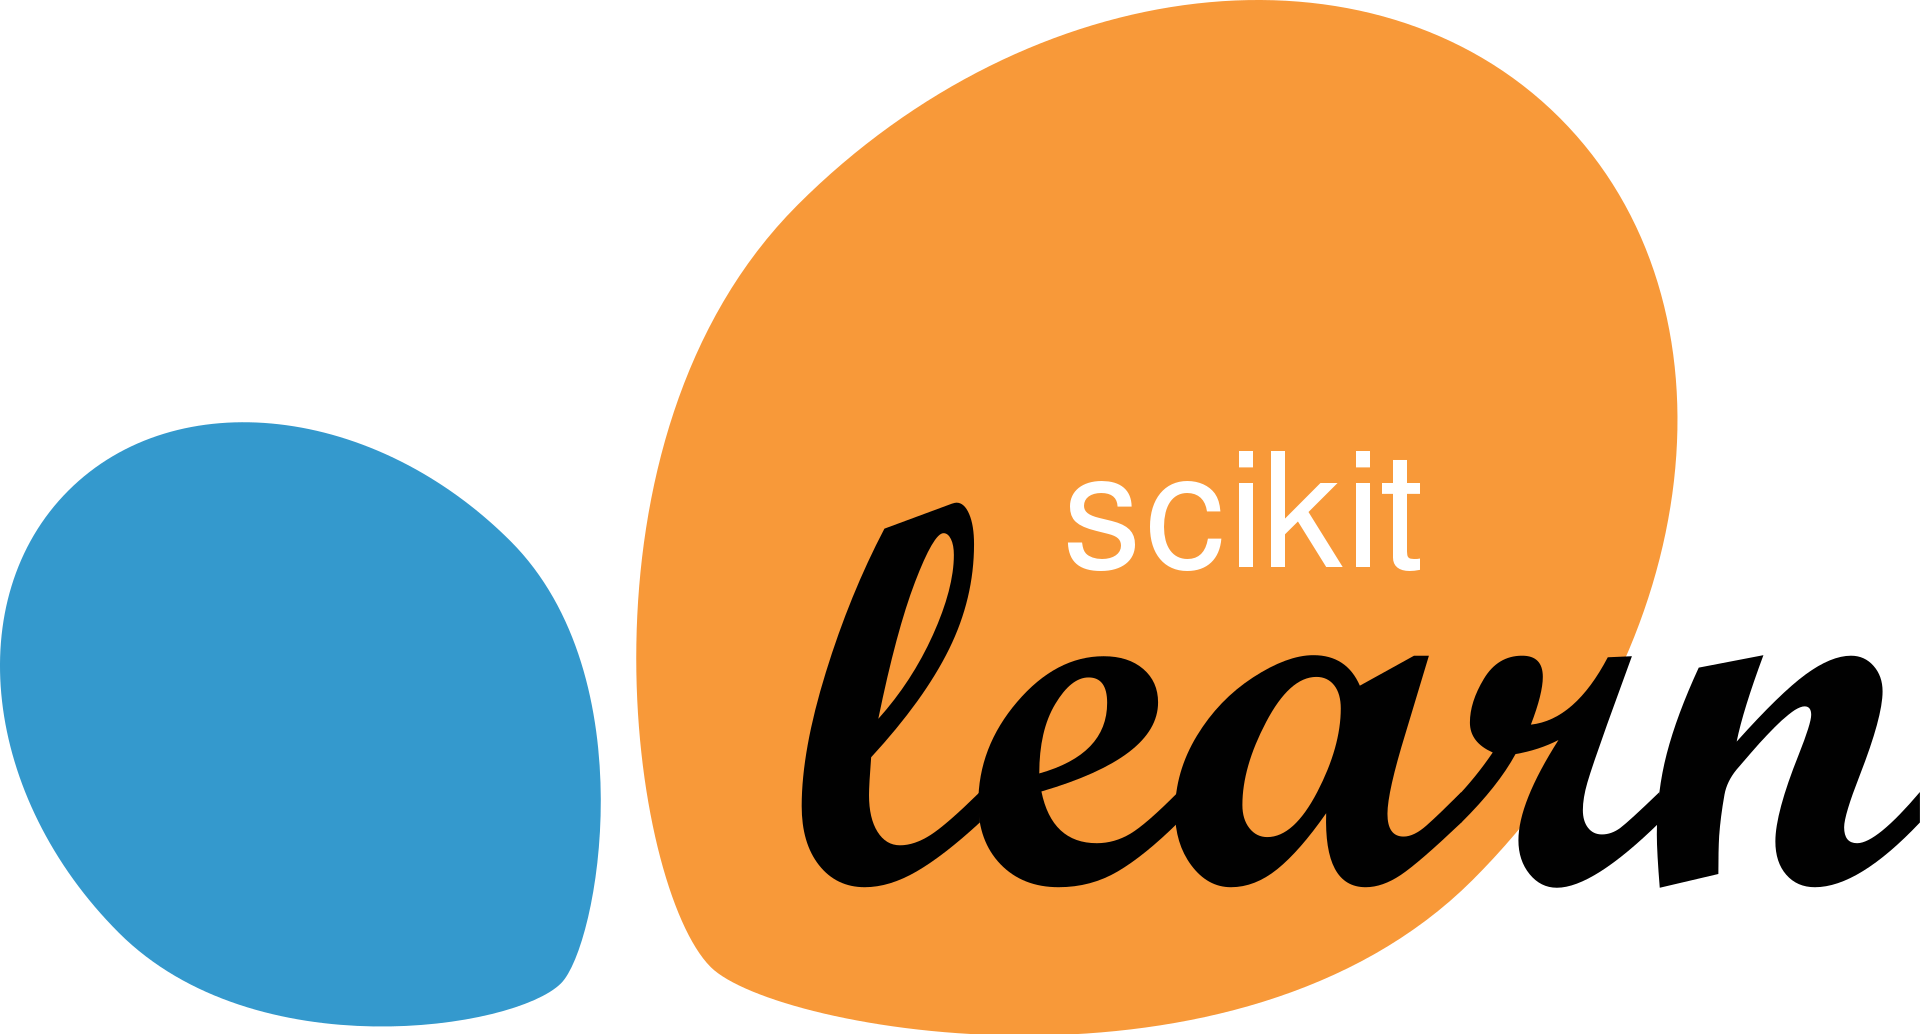

Source: https://en.wikipedia.org/wiki/Scikit-learn#/media/File:Scikit_learn_logo_small.svg

# 1. Creating a treebank consisting tokens and tags

### 1.1. Import modules, conllu library to parse CoNLL-U

In [1]:
import conllu
import pickle
import time

### 1.2.1. Define a function to create one or more treebanks without overwriting

In [2]:
def create_treebank(conllu_file):
    """Fetches data from the conllu file.
    
    Parses the annotated data and extracts Tokens and POS-Tags.
        Creates a clean list of sentences containing tuples of
        tokens and POS-Tags and stores it as a pickle file.
        Strings will be UTF-8 encoded.
    
    Args:
        conllu_file (str):  Name of the conllu file that needs to be accessed
    
    Returns:
        A string indicating that the treebank has been created
    """
    # open the data from conllu file and save it under "data"
    data = open(conllu_file, "r", encoding="utf-8")

    # read the content of file and assign under "annotations"
    annotations = data.read()

    # use conllu.parse() to parse and store under "sentences"
    sentences = conllu.parse(annotations)

    # extract the tokens and POS-tags from the annotated data
    tagged_sents = [[(tag["form"], tag["upos"]) for tag in sents]
                    for sents in sentences]
    
    # remove token that are "_"
    for sents in tagged_sents:
        for token in sents:
            if token[0] == "_":
                sents.remove(token)
    
    # remove POS-tags that are "_"
    for sents in tagged_sents:
        for pos in sents:
            if pos[1] == "_":
                sents.remove(pos)
    
    # store the treebank in a pickle file
    with open(time.strftime("treebank_%H.%M.%S.pkl"), "wb") as f:
        for sents in tagged_sents:
            for tupl in sents:
                tuple(tupl)
        pickle.dump(tagged_sents, f)
    
    return "Treebank is created"

### 1.2.2. Create treebank from conllu file

In [3]:
# create treebank from test-conllu
create_treebank("kmr_mg-ud-test.conllu")

'Treebank is created'

### 1.2.3. To get as much data as possible

In [4]:
# create another treebank from train-conllu
create_treebank("kmr_mg-ud-train.conllu")

'Treebank is created'

### 1.3.1 Define a function to join the created treebanks together

In [5]:
def join_treebanks(conllu_file_1, conllu_file_2):
    """Imports data from two pickle files and joins them together.
    
    Args:
        conllu_file_1 (str): The name of the first pickle file
        conllu_file_2 (str): The name of the second pickle file
    
    Returns:
        A string indicating that the joined treebank has been created
    """
    # import the data from pickle file
    with open(conllu_file_1, "rb") as f:
        first_treebank = pickle.load(f)
    
    # import the data from pickle file
    with open(conllu_file_2, "rb") as f:
        second_treebank = pickle.load(f)
    
    # join both treebanks together
    joined_treebank = first_treebank + second_treebank
    
    # store the new joined treebank in pickle file
    with open(time.strftime("joined_treebank_%H.%M.%S.pkl"), "wb") as f:
        for sents in joined_treebank:
            for tupl in sents:
                tuple(tupl)
        pickle.dump(joined_treebank, f)
    
    return "Joined treebank is created"

### 1.3.2. Join both of the pickle files together

In [6]:
# join treebanks together
join_treebanks("treebank_20.23.07.pkl", "treebank_20.23.08.pkl")

'Joined treebank is created'

# 2. Preprocessing the data

### 2.1. Import modules and libraries

In [7]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
vectoriser = DictVectorizer(sparse=False)

### 2.2.1. Import the created treebank

In [8]:
# import the data from pickle file
with open("joined_treebank_16.32.37.pkl", "rb") as f:
    tagged_sents = pickle.load(f)

### 2.2.2. Check how many sentences and tokens included in the treebank

In [9]:
# check the number of sentences and tokens in the treebank
numb_sents = len(tagged_sents)
numb_tokens = sum(len(sent) for sent in tagged_sents)

print("The treebank consists of", numb_sents,"tagged sentences and",
      numb_tokens, "tokens.")

The treebank consists of 754 tagged sentences and 10198 tokens.


### 2.2.3 Sort the data as tokens and tags

In [10]:
# extract the tokens and tags from treebank in separated lists
tokens = [[token[0] for token in sent] for sent in tagged_sents]
tags = [[tag[1] for tag in sent] for sent in tagged_sents]

### 2.3.1. Extract features

In [11]:
def extract_features(sentence, index):
    """Creates a dict of eight features.
    
    Extracts eight defined features for each token.
    
    Args:
        sentence (list): sentence i.e. list of tokens
        index (int): index of token in sentence
    
    Returns:
        Dictionary of features for a given token
    """
    token = sentence[index]
    prev_token = ""
    
    if index > 0:
        prev_token = sentence[index - 1]
    is_number = False
    try:
        if float(token):
            is_number = True
    except:
        pass
    
    features_dict = {
        "token": token,
        "lower_cased_token": token.lower(),
        "prev_token": prev_token,
        "suffix1": token[-1],
        "suffix2": token[-2:],
        "suffix3": token[-3:],
        "is_capitalized": token.upper() == token and token.isalpha(),
        "is_number": is_number}
    
    return features_dict

### 2.3.2. Test the featuring function 

In [12]:
# Test the function with a token
print("Original sent with tags:", tagged_sents[0])

# get the tokens
example_sent = [[token for token in sent][0] for sent in tagged_sents[0]]
print("Only tokens: " + str(example_sent))

# the features for 'Nîsanê'
extract_features(example_sent, 1)

Original sent with tags: [('Meheke', 'NOUN'), ('Nîsanê', 'NOUN'), ('bû', 'AUX'), ('.', 'PUNCT')]
Only tokens: ['Meheke', 'Nîsanê', 'bû', '.']


{'token': 'Nîsanê',
 'lower_cased_token': 'nîsanê',
 'prev_token': 'Meheke',
 'suffix1': 'ê',
 'suffix2': 'nê',
 'suffix3': 'anê',
 'is_capitalized': False,
 'is_number': False}

### 2.3.3. Implement a function to feature data

In [13]:
def process_data(data):
    """Extracts features for all tokens.
    
    Args:
        data (list): list of lists - each list represents a sentence
    
    Returns:
        List of dicts containing features for each token
    """
    X_features = []
    
    for sent in data:
        for k in range(len(sent)):
            X_features.append(extract_features(sent, k))
    
    return X_features

### 2.4.1 Implement a function to include development set

In [14]:
def create_train_dev_test_split(X, y):
    """Splits data into train and test.
    
    Splits test data into dev and test data.
    
    Args:
        X (list): list of tokens
        y (list): list of tags
    
    Returns:
        Six lists: X_train, y_train, X_dev, y_dev, X_test, y_test
    """
    # use 80% of data for training and 20% for test and development
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=5)
    
    # divide 20% of data put aside in previous step into dev and test sets
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=5)
    
    return (X_train, y_train, X_dev, y_dev, X_test, y_test)

### 2.4.2. Split the data into train, development and  test

In [15]:
# create train, dev, test data
X_train, y_train, X_dev, y_dev, X_test, y_test = create_train_dev_test_split(
    tokens,
    tags)

### 2.4.3. Check the split of data

In [16]:
# how many sentences does each data set have
print("train set: ", len(X_train), len(y_train))
print("dev set: ",  len(X_dev), len(y_dev))
print("test set: ",  len(X_test), len(y_test))

train set:  603 603
dev set:  75 75
test set:  76 76


### 2.5.1. Fit, transform and vectorize the lists of tokens

In [17]:
# fit, transform and vectorize the data
X_train_vectorized = vectoriser.fit_transform(process_data(X_train))
X_dev_vectorized = vectoriser.transform(process_data(X_dev))
X_test_vectorized = vectoriser.transform(process_data(X_test))

### 2.5.2. Check the shapes of generated arrays

In [18]:
# print the shapes of data
print(X_train_vectorized.shape)
print(X_dev_vectorized.shape)
print(X_test_vectorized.shape)

(8190, 8897)
(974, 8897)
(1034, 8897)


### 2.6.1 In order to flatten the lists of tags

In [19]:
def flatten(lst):
    """Flattens a list out of list of lists.
    
    Args:
        lst (list): list of lists
    
    Returns:
        A flatten list
    """
    return [item for sublist in lst for item in sublist]

### 2.6.2. Flatten the lists of tags

In [20]:
# flatten the list of tags
Y_train_flat = flatten(y_train)
Y_dev_flat = flatten(y_dev)
Y_test_flat = flatten(y_test)

# 3. Training the model

### 3.1 Import and initialize ExtraTreesClassifier, import cross validation

In [21]:
from sklearn import ensemble
clf = ensemble.ExtraTreesClassifier(n_estimators=100, criterion="entropy",
                                    random_state=None, verbose=2)
from sklearn.model_selection import cross_val_score
import time
import pickle

### 3.2.1. Define a function to train and store the pos-tag model

In [22]:
def train(train_set, tags):
    """Takes a numpy array of vectors and list of tags and trains
        a pos tagger using ensemble.ExtraTreesClassifier.
    
    Args:
        train_set (np.array): array of vectorized features
        tags (list): list of the tags
    
    Returns:
        The trained pos tagger model stored in a pickle file
    """
    clf.fit(train_set, tags)
    
    # store the model
    with open(time.strftime("pos_tag_model_%H.%M.%S.pkl"), "wb") as f:
        pickle.dump(clf, f)
    
    return "Done"

### 3.2.2. Train the model

In [23]:
# train the pos tag model
train(X_train_vectorized, Y_train_flat)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


'Done'

### 3.4. Cross validation

### 3.4.1. Import the trained model to do cross validation

In [24]:
# import the trained model to do cross validation
with open("pos_tag_model_17.26.08.pkl", "rb") as f:
    pos_tag_model = pickle.load(f)

### 3.4.2. Calculate cross validation

In [25]:
# calculate cross validation score
scores = cross_val_score(pos_tag_model, X_train_vectorized, Y_train_flat, cv=5)

C:\Users\Radwa\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### 3.4.3. Mean and standard deviation

In [26]:
# the mean and standard deviation
print("Accuracy is %.2f with a standard deviation of %.2f" % (scores.mean(),
                                                                scores.std()))

Accuracy is 0.88 with a standard deviation of 0.01


# 4. Evaluating the results

### 4.1. Import libraries, packages, modules, metrics

In [27]:
import pickle
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### 4.2. Import the trained model

In [28]:
# import the trained model
with open("pos_tag_model_17.26.08.pkl", "rb") as f:
    pos_tag_model = pickle.load(f)

### 4.3. How to get Precision, Recall, and F-score, accuracy?

<div>
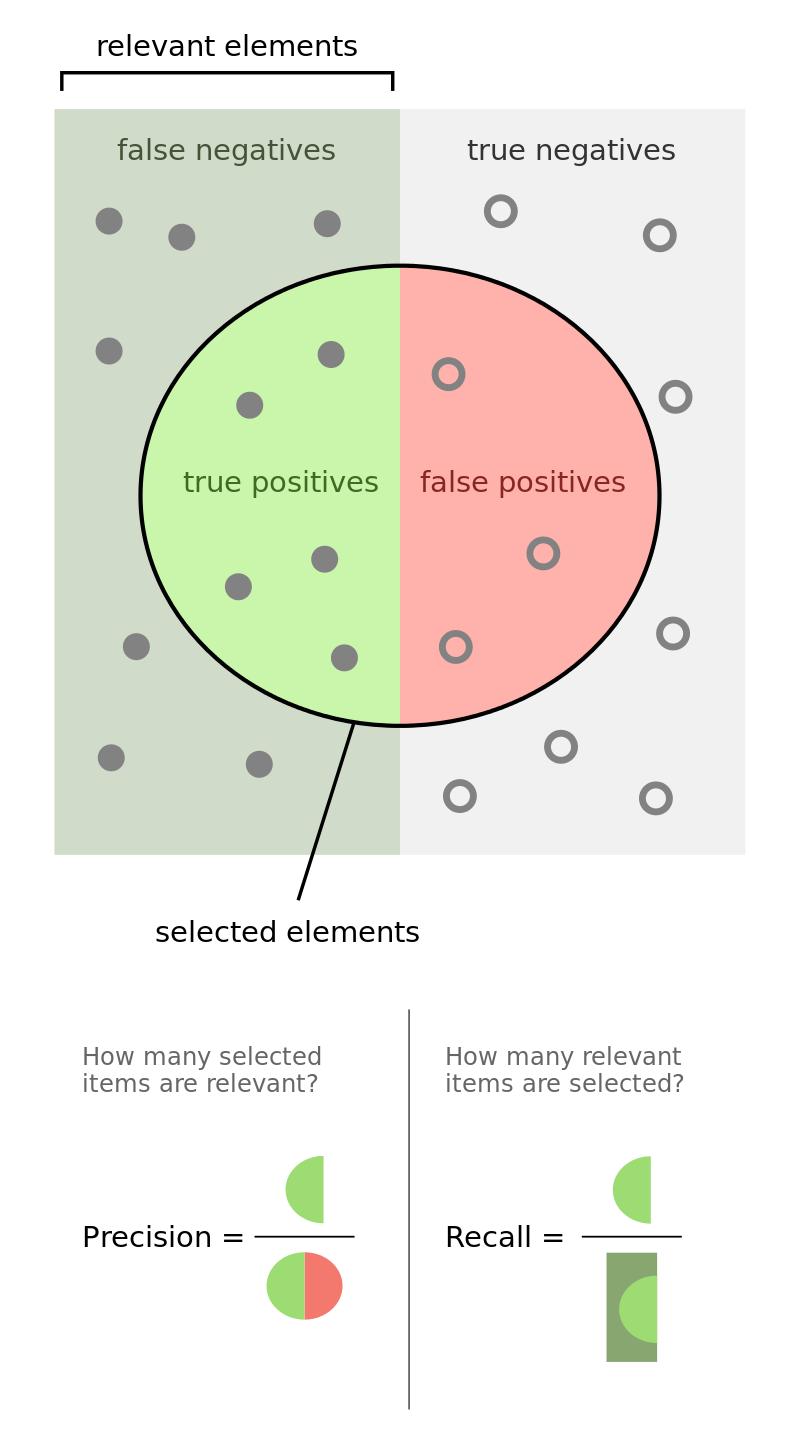
</div>

Source: https://en.wikipedia.org/wiki/Precision_and_recall#/media/File:Precisionrecall.svg

\begin{equation*}
precision=\frac{TP}{TP + FP}
\end{equation*}

\begin{equation*}
recall=\frac{TP}{TP + FN}
\end{equation*}

\begin{equation*}
F1=\frac{2 \times precision \times recall}{precision + recall}
\end{equation*}

\begin{equation*}
accuracy=\frac{TP + TN}{TP + FN + TN + FP}
\end{equation*}

### 4.3.1. Predict on development data

In [29]:
# predict on development data
predicted_tags_dev = pos_tag_model.predict(X_dev_vectorized)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### 4.3.2. Compute Precision, Recall, F-score on development set

In [30]:
# caculate Precision, Recall, F-score
precision_dev, recall_dev, fscore_dev, _ = precision_recall_fscore_support(
    predicted_tags_dev.tolist(), Y_dev_flat, average='macro')

# calculate accuracy
accuracy_dev = accuracy_score(predicted_tags_dev.tolist(), Y_dev_flat)

### 4.3.3. Results on dev set

In [31]:
# Precision, Recall, score and Accuracy on dev data
print('Results on dev set:')
print()
print("Precision_dev: %.2f" % round(precision_dev * 100, 2))
print("Recall_dev: %.2f" % round(recall_dev * 100, 2))
print("F-score_dev: %.2f" % round(fscore_dev * 100, 2))
print("Accuracy_dev: %.2f" % round(accuracy_dev * 100, 2))

Results on dev set:

Precision_dev: 81.61
Recall_dev: 88.65
F-score_dev: 84.51
Accuracy_dev: 90.25


### 4.3.4. Confusion matrix

In [32]:
def visualize_confusion_matrix(predicted_tags, gold_tags):
    """Visualizes the confusion matrix based on
        predicted tags and gold tags.
    
    Args:
        predicted_tags (list): predicted tags - dev or test
        gold_tags (list): gold tags - dev or test
    
    Returns:
        Visualization of the confusion matrix
    """
    plt.rcParams["figure.figsize"] = (15,15)
    all_tags = list(set(predicted_tags + gold_tags))
    cm = confusion_matrix(gold_tags, predicted_tags, labels=all_tags)
    
    cm_display = ConfusionMatrixDisplay(cm, display_labels=all_tags).plot()
    
    plt.show()

### 4.3.5. Visualize the confusion matrix on development set

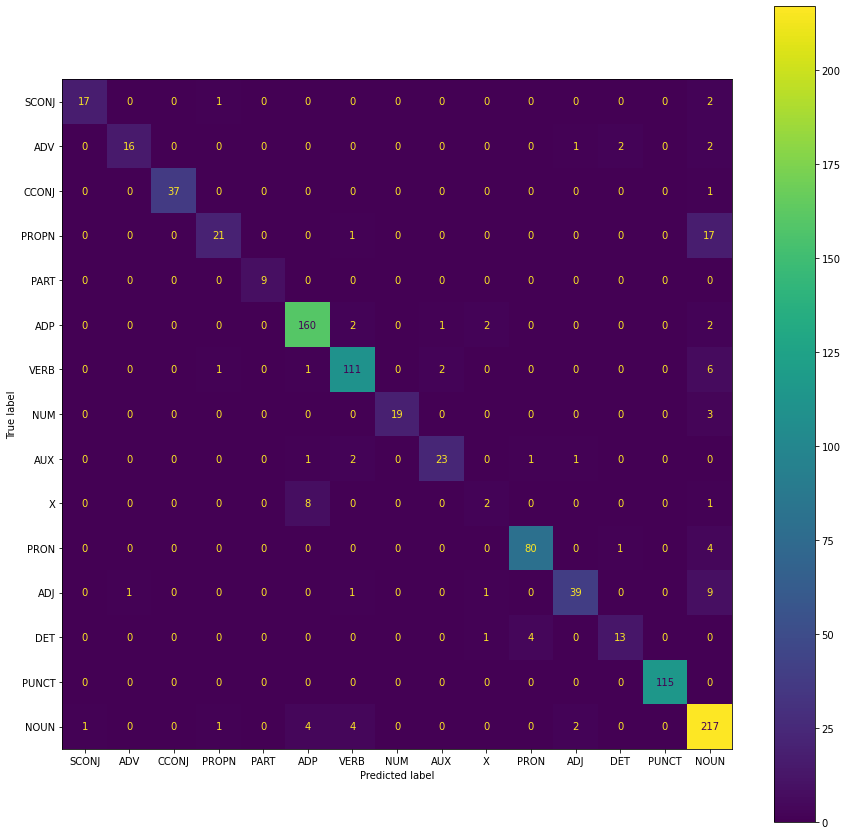

In [33]:
# visualize the confusion matrix
visualize_confusion_matrix(predicted_tags_dev.tolist(), Y_dev_flat)

### 4.4.1 It is time to predict on test data

In [34]:
# predict on test data
predicted_tags_test = pos_tag_model.predict(X_test_vectorized)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### 4.4.2. Compute precision, Recall, and F-score, accuracy on test data

In [35]:
# calculate Precision, Recall, F-score
precision_test, recall_test, fscore_test, _ = precision_recall_fscore_support(
    predicted_tags_test.tolist(), Y_test_flat, average='macro')

# calculate accuracy
accuracy_test = accuracy_score(predicted_tags_test.tolist(), Y_test_flat)

### 4.4.3. Results on test data

In [36]:
# Precision, Recall, score and Accuracy on test data
print("Results on test set:")
print()
print("Precision_test: %.2f" % round(precision_test * 100, 2))
print("Recall_test: %.2f" % round(recall_test * 100, 2))
print("F-score_test: %.2f" % round(fscore_test * 100, 2))
print("Accuracy_test: %.2f" % round(accuracy_test * 100, 2))

Results on test set:

Precision_test: 81.89
Recall_test: 85.97
F-score_test: 83.59
Accuracy_test: 89.17


### 4.4.4. Visualize the confusion matrix on test data

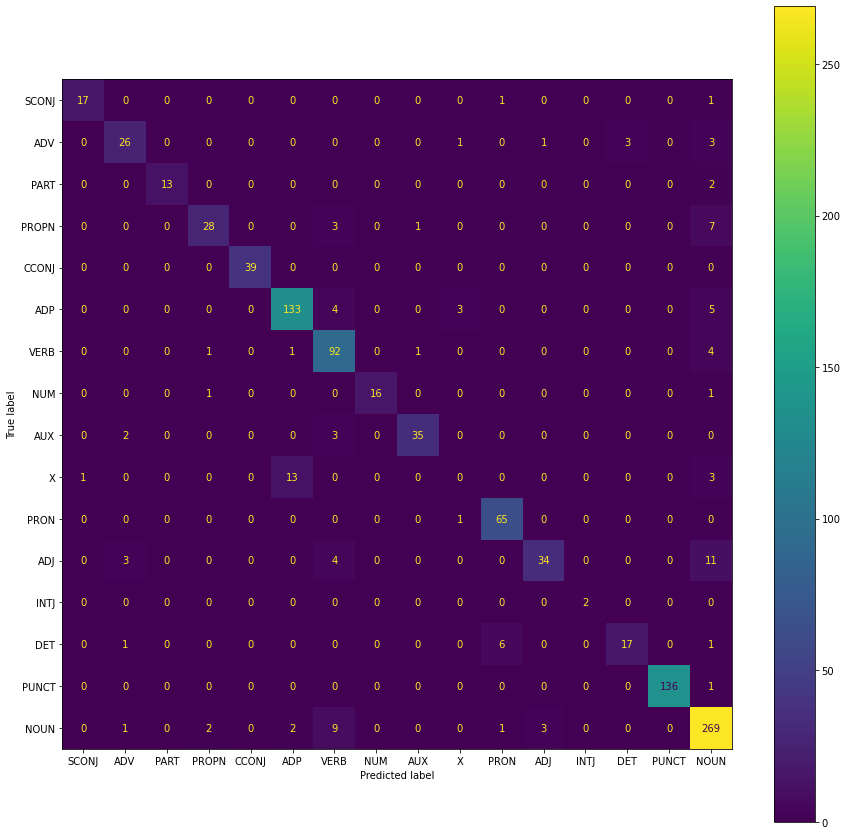

In [37]:
# visualize the confusion matrix
visualize_confusion_matrix(predicted_tags_test.tolist(), Y_test_flat)

# Some linguistic analyses

### 5. Finding most frequent FP & FN

### 5.1. Import libraries, modules

In [38]:
import pickle
import pandas as pd
df = pd.DataFrame.from_dict
from IPython.display import display_html
from collections import Counter

### 5.1.1. Import treebank

In [39]:
# import the data from pickle file
with open("joined_treebank_16.32.37.pkl", "rb") as f:
    tagged_sents = pickle.load(f)

### 5.2.1. Define a function to find "false positive" tags

In [40]:
def FP(y_predicted, y_gold):
    """Calculates the false positive predicted tags.
    
    Args:
        y_predicted (list): list of predicted tags
        y_gold (list): list of gold tags
    
    Returns:
        A list of false positive predicted tags
    """
    lst_fp = []
    
    for i in range(len(y_predicted)):
        if y_predicted[i] != y_gold[i]:
            lst_fp.append(y_predicted[i])
    
    return lst_fp

### 5.2.2. Define a function to find "false negative" tags

In [41]:
def FN(y_gold, y_predicted):
    """Calculates the false negative predicted tags.
    
    Args:
        y_predicted (list): list of predicted tags
        y_gold (list): list of gold tags
    
    Returns:
        A list of false negative predicted tags
    """
    lst_fn = []
    
    for i in range(len(y_gold)):
        if y_gold[i] != y_predicted[i]:
            lst_fn.append(y_gold[i])
    
    return lst_fn

### 5.2.3. Define a function to get the frequencies of FP and FN tags

In [42]:
def frequencies(lst):
    """Calculates frequencies of tags in a given list.
    
    Args:
        lst (list): list of tags
    
    Returns:
        A sorted dict of key=tags, value=frequencies
    """
    frequencies = Counter(lst)
    
    # sort the dict of frequencies
    frequencies_sorted = {word: frequencies[word]
                          for word in sorted(frequencies,
                                             key=frequencies.get,
                                             reverse=True)}
    
    return(frequencies_sorted)

### 5.2.4. Define a function to visualize DataFrames

In [43]:
def display_dfs(*args):
    """Visualizes DataFrames side by side.
    
    Args:
        *args (DataFrame): one or more data frames
    
    Returns:
        DataFrames displayed side by side
    """
    html_str = ""
    
    for df in args:
        html_str += df.to_html()
    
    display_html(html_str.replace("table", "table style='display:inline'"),
                 raw=True)

### 5.3.1. Find FP and FN in dev data

In [44]:
# find false positives and false negatives in dev data
fp_dev = FP(predicted_tags_dev.tolist(), Y_dev_flat)
fn_dev = FN(Y_dev_flat, predicted_tags_dev.tolist())

### 5.3.2. Check the frequencies of FP and FN tags dev set

In [45]:
# find frequencies in dev data
freq_fp_dev = frequencies(fp_dev)
freq_fn_dev = frequencies(fn_dev)

### 5.3.3 Create DataFrames from dicts

In [46]:
# create DataFrames from dicts
df_fp_dev = df(freq_fp_dev, orient="index", columns=["FP_dev"])
df_fn_dev = df(freq_fn_dev, orient="index", columns=["FN_dev"])

### 5.3.4. Visualize the frequencies of FP & FN in dev data

In [47]:
# visualize frequencies FP and FN in dev set
display_dfs(df_fp_dev, df_fn_dev)

,FP_dev
NOUN,47
ADP,14
VERB,10
PRON,5
ADJ,4
X,4
DET,3
PROPN,3
AUX,3
SCONJ,1


### 5.4.1. Find FP and FN in test data

In [48]:
# find false positives and false negatives in test data
fp_test = FP(predicted_tags_test.tolist(), Y_test_flat)
fn_test = FN(Y_test_flat, predicted_tags_test.tolist())

### 5.4.2. Check the frequencies of FP and FN tags in test set

In [49]:
# find frequencies in test data
freq_fp_test = frequencies(fp_test)
freq_fn_test = frequencies(fn_test)

### 5.4.3 Create DataFrames from dicts

In [50]:
# create DataFrames
df_fp_test = df(freq_fp_test, orient="index", columns=["FP_test"])
df_fn_test = df(freq_fn_test, orient="index", columns=["FN_test"])

### 5.4.4. Visualize the frequencies of FP & FN in test data

In [51]:
# visualize frequencies of FP and FN in test set
display_dfs(df_fp_test, df_fn_test)

,FP_test
NOUN,39
VERB,23
ADP,16
PRON,8
ADV,7
X,5
ADJ,4
PROPN,4
DET,3
AUX,2


### 5.5. Which morphological features do nouns share with proper nouns and adjecives?

### 5.5.1. Define a function to find tokens contain Izafe 'ê'

In [52]:
def find_Izafe(treebank, tag, suffix):
    """Finds all tokens in treebank with the given tag and ending.
    
    Args:
        treebank (list): POS-tag treebank
        tag (str): tag to be searched
        suffix (str): Izafe-ending to be searched
    
    Returns:
        List of matched tokens
    """
    lst_IZ = []
    
    for sent in treebank:
        for word in sent:
            if tag in word[1] and word[0].endswith(suffix):
                lst_IZ.append(word[0])
    
    return(lst_IZ)

### 5.5.2. Find nouns, proper nouns and adjectives ending with 'ê'

In [53]:
NOUN_Izafe = find_Izafe(tagged_sents, "NOUN", "ê")
PROPN_Izafe = find_Izafe(tagged_sents, "PROPN", "ê")
ADJ_Izafe = find_Izafe(tagged_sents, "ADJ", "ê")

### 5.5.3. Extract features

In [54]:
# get lists of features
NOUN_FEAT = extract_features(NOUN_Izafe, 3)
ADJ_FEAT = extract_features(ADJ_Izafe, 3)
PROPN_FEAT = extract_features(PROPN_Izafe, 3)

### 5.5.4. Create DataFrames

In [55]:
# create DataFrames from dicts
NOUN_FEAT_df = df(NOUN_FEAT, orient="index", columns=["NOUN_FEAT"])
ADJ_FEAT_df = df(ADJ_FEAT, orient="index", columns=["ADJ_FEAT"])
PROPN_FEAT_df = df(PROPN_FEAT, orient="index", columns=["PROPN_FEAT"])

### 5.5.5. Visualize features

In [56]:
# display DataFrames side by side
display_dfs(NOUN_FEAT_df, ADJ_FEAT_df, PROPN_FEAT_df)

,NOUN_FEAT
token,serê
lower_cased_token,serê
prev_token,serê
suffix1,ê
suffix2,rê
suffix3,erê
is_capitalized,False
is_number,False
,ADJ_FEAT
token,saliyê


### 6. What is behind the POS-tag 'X'?

### 6.1. Check the tokens tagged with 'X'

In [57]:
# create list of 'X' tagged tokens
X_tokens = []

for sent in tagged_sents:
    for word in sent:
        if word[1] == "X":
            X_tokens.append(word[0])

# length of X_tokens
len(X_tokens)

149

### 6.2. Check if X_tokens can be tagged differently

In [58]:
# create list of X_distinct
X_distinct = []

for sent in tagged_sents:
    for word in sent:
        if word[0] in set(X_tokens) and word[1] != "X":
            X_distinct.append(word[0])

# length of X_distinct
len(X_distinct)

725

### 6.3. Check if X_tokens cannot be tagged differently

In [59]:
# create list of correct 'X'
X_correct = []

for token in X_tokens:
    if token not in set(X_distinct):
        X_correct.append(token)

# length of X_correct
len(X_correct)

13

### 6.4. Check the mistaken 'X'

In [60]:
# create list of incorrect 'X'
X_incorrect = []

for token in X_tokens:
    if token in set(X_distinct):
        X_incorrect.append(token)

# length of X_incorrect
len(X_incorrect)

136

### 6.5.1. Check the frequencies

In [61]:
# find frequencies on 'X' tagged tokens
freq_X_distinct = frequencies(X_distinct)
freq_X_incorrect = frequencies(X_incorrect)
freq_X_correct = frequencies(X_correct)

### 6.5.2. Create DataFrames from dicts

In [62]:
# create DataFrames from dicts
freq_X_distinct_df = df(freq_X_distinct, orient="index",
                        columns=["X_distinct"])
freq_X_incorrect_df = df(freq_X_incorrect, orient="index",
                         columns=["X_incorrect"])
freq_X_correct_df = df(freq_X_correct, orient="index",
                       columns=["X_correct"])

### 6.5.3. Visualize frequencies of X_distinct, X_incorrect and X_correct

In [63]:
# display DataFrames side by side
display_dfs(freq_X_distinct_df, freq_X_incorrect_df, freq_X_correct_df)

,X_distinct
bi,192
ji,159
li,134
bo,40
Ji,35
ber,33
Li,30
gelek,26
Bi,21
pê,16


### 6.5.4 Results on 'X' tagged tokens

In [64]:
# which information do we have now?
print("The set of tokens tagged with 'X' contains "
      + str(len(set(X_tokens)))
      + " tokens, " + str(len(set(X_distinct)))
      + " are incorrect, " + str(len(set(X_correct)))
      + " are real 'X' tags.")

The set of tokens tagged with 'X' contains 30 tokens, 20 are incorrect, 10 are real 'X' tags.


### 6.6.1. X_tokens tagged with 'ADP' in UD-treebank

In [65]:
# create list of tokens tagged with 'ADP'
X_tokens_ADP = []

for sent in tagged_sents:
    for word in sent:
        if word[0] in set(X_tokens) and word[1] == "ADP":
            X_tokens_ADP.append(word[0])

# length of X_tokens_ADP
len(X_tokens_ADP)

658

### 6.6.2. Check the frequencies

In [66]:
# create a dict with frequencies
freq_X_tok_ADP = frequencies(X_tokens_ADP)

### 6.6.3. Create and visualize a DataFrame of X_tokens_ADP

In [67]:
# create a DataFrame
freq_X_tokens_ADP_df = df(freq_X_tok_ADP, orient="index",
                          columns=["X_tokens_ADP"])
# visualize the DataFrame
freq_X_tokens_ADP_df

,X_tokens_ADP
bi,192
ji,157
li,134
bo,40
Ji,35
ber,33
Li,30
Bi,21
pê,15
ta,1


# 7. POS-tags frequencies in the data source

### 7.1. Check the frequencies of POS-tags

In [68]:
# count the tags in UD-treebank
freq_tags = frequencies(flatten(tags))

# count the percentage of each tag
percentage = {k: round(v / sum(freq_tags.values()) * 100, 2)
               for k, v in freq_tags.items()}

### 7.2. Visualize tags and percentages in UD-treebank

In [69]:
# visualize percentages of tags
df(percentage, orient="index", columns=["Percent"])

,Percent
NOUN,26.02
ADP,15.60
PUNCT,12.54
VERB,10.93
PRON,8.07
PROPN,4.33
ADJ,4.30
CCONJ,3.58
AUX,3.32
ADV,2.43


### Go to repository: https://github.com/RadwanRasul/nlp-project-kurdish